In [6]:
#a)
import pandas as pd
data = pd.read_csv("compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]
#display(data.columns)
print(data["race"].unique())
display(data)

['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,

In [3]:
#b)
def finn_sannsynligheter(data):
    #Finner de som ble klassifisert som høy eller lav risiko:
    High_risk = data[data["score_text"].isin(["Medium","High"])]
    Low_risk = data[data["score_text"] == "Low"]

    #Finner hvor bra COMPAS gjorde det:
    Falsk_positiv = High_risk[High_risk["two_year_recid"] == 0]
    Sann_positiv = High_risk[High_risk["two_year_recid"] >= 1]
    Falsk_negativ = Low_risk[Low_risk["two_year_recid"] >= 1]
    Sann_negativ = Low_risk[Low_risk["two_year_recid"] == 0]

    #Finner estimerte sannsynlihgetsverdier:
    p_Falsk_positiv = Falsk_positiv.size/High_risk.size
    p_Sann_positiv = Sann_positiv.size/High_risk.size
    p_Falsk_negativ = Falsk_negativ.size/Low_risk.size
    p_Sann_negativ = Sann_negativ.size/Low_risk.size
    return p_Falsk_positiv, p_Sann_positiv, p_Falsk_negativ, p_Sann_negativ

def print_sannsynligheter(data):
    p_Falsk_positiv, p_Sann_positiv, p_Falsk_negativ, p_Sann_negativ = finn_sannsynligheter(data)
    #Printer sannsynlighetsverdiene:
    print("falsk positiv: ",p_Falsk_positiv)
    print("sann positiv: ",p_Sann_positiv)
    print("falsk negativ: ",p_Falsk_negativ)
    print("sann negativ: ",p_Sann_negativ)
    print()

#Finner de forskjellige typene raser:
print("Hele befolkning:")
print_sannsynligheter(data)

for kjønn in ["Male","Female"]:
    nydata = data[data["sex"] == kjønn]
    print("for ",kjønn,":")
    print_sannsynligheter(nydata)

for rase in ["Caucasian","African-American"]:
    nydata = data[data["race"] == rase]
    print("for ",rase,":")
    print_sannsynligheter(nydata)


Hele befolkning:
falsk positiv:  0.37004725554343876
sann positiv:  0.6299527444565612
falsk negativ:  0.31452791581408945
sann negativ:  0.6854720841859105

for  Male :
falsk positiv:  0.3463736263736264
sann positiv:  0.6536263736263737
falsk negativ:  0.33394562821454815
sann negativ:  0.6660543717854519

for  Female :
falsk positiv:  0.4831932773109244
sann positiv:  0.5168067226890757
falsk negativ:  0.23891273247496422
sann negativ:  0.7610872675250357

for  Caucasian :
falsk positiv:  0.4051724137931034
sann positiv:  0.5948275862068966
falsk negativ:  0.2899786780383795
sann negativ:  0.7100213219616205

for  African-American :
falsk positiv:  0.35046473482777474
sann positiv:  0.6495352651722253
falsk negativ:  0.3514115898959881
sann negativ:  0.6485884101040119



In [4]:
def p_misklassifisert(key,category,data,keys=None,risk="High"):
    """
    Gir sannsynligheten for at man har blit misklassifisert som høy risiko, 
    gitt at man er i en viss kategori (rase, kjønn, etc)

    f: står for feil
    k: står for at det er den spesifikke kategorien.
    """
    #Finner de som ble klassifisert som høy risiko:
    if keys!=None:
        data = data[data[category].isin(keys)]
    if risk == "High":
        High_risk = data[data["score_text"].isin(["Medium","High"])]
    else:
        High_risk = data[data["score_text"] == "Low"]

    #Finner hvor bra COMPAS gjorde det:
    Falsk_positiv = High_risk[High_risk["two_year_recid"] == 0]

    #P(misklassifisert):
    p_f=(Falsk_positiv.size)/High_risk.size

    #P(misklassifisert|man er i kategorien)
    p_f_k = (Falsk_positiv[Falsk_positiv[category] == key].size
             /High_risk[High_risk[category] == key].size)
    
    #P(man er i kategorien)
    p_k = High_risk[High_risk[category] == key].size/High_risk.size
    
    #Her bruker jeg bayes setning:
    #P(man er i kategorien| man er misklassifisert)
    p_k_f = (p_f_k*p_k)/p_f

    return p_k_f

print(p_misklassifisert("African-American","race",data,["African-American","Caucasian"],risk = "High"))
print(p_misklassifisert("Caucasian","race",data,["African-American","Caucasian"],risk = "Low"))

            

0.6944745395449621
0.5336538461538461


1.4546067057321943
accuracy:  75.4 %


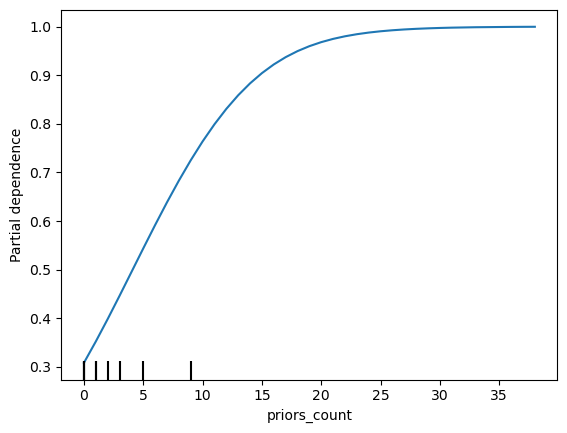

In [17]:
import sklearn.linear_model as skl
import sklearn.metrics as skm
import numpy as np

#X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid","juv_fel_count","juv_misd_count","juv_other_count"]]
categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)
Y = data["score_text"] != "Low"

model = skl.LogisticRegression(max_iter = 1000)
model.fit(X,Y)
coef = model.coef_[0][list(X.columns).index("race_African-American")]

def sigmoid(x):
    return np.where(x>0,1/(1+np.exp(-x)),np.exp(x)/(1+np.exp(x)))
b = model.intercept_

control = sigmoid( b )
racialBias = np.exp( coef) / (1 - control + (control * np.exp(coef)))
print(racialBias[0])
from sklearn.inspection import  PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X,[0])
print("accuracy: ",round(skm.accuracy_score(model.predict(X),Y)*100,1),"%")